### 레이블 부족문제 다루기
| **특징**            | **Zero-shot**                              | **Few-shot**                              |
|:----------------------:|:--------------------------------------------:|:-------------------------------------------:|
| **레이블 수**       | 없음                                       | 매우 적음                                |
| **모델 접근 방식**  | 사전 학습된 모델의 일반화 능력 활용         | 제한된 데이터로 추가 학습 또는 조정       |
| **사용 사례**       | 완전히 새로운 태스크                        | 유사한 태스크지만 데이터가 적음          |

- 레이블 데이터 ⬇️, 레이블 안된 데이터 ⬆️ 일때
    - UDA(Unsupervised Data Augmentation) : 데이터 증강
    - UST(Uncertainty-aware Self-training) : 불확실성(softmax 또는 베이지안 분포로 파악)이 낮은 모델만 추출

### 데이터 셋 불러오고 전처리 하기

In [1]:
import pandas as pd

df = pd.read_json('dataset/github-issues-transformers.jsonl', lines=True)

print("df 크기 : ",df.shape)
print("df cols : ", [col for col in df.columns])
display("df labels : ",df.labels[2])

df 크기 :  (9930, 26)
df cols :  ['url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments', 'created_at', 'updated_at', 'closed_at', 'author_association', 'active_lock_reason', 'body', 'performed_via_github_app', 'pull_request']


'df labels : '

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

In [2]:
cols = ["url", "id", "title" , "user" , "labels", "state" , "created_at", "body"]

df = df[cols]

In [3]:
# 필요한 밸류만 추출
df["labels"] = df["labels"].map(lambda x: [i["name"] for i in x])

In [4]:
# 각 글에 대하여 라벨 갯수
df["labels"].apply(lambda x: len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [5]:
# 각 라벨 별 개수 확인
df["labels"].explode().value_counts().to_frame().head(8).T

labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


In [6]:
# 필용한 라벨만
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

In [7]:
df["labels"] = df["labels"].apply(lambda x : [label for label in x
                                              if label in label_map.keys()])

In [8]:
df["split"] = "unlabeled"
mask_over_zero = df["labels"].apply(lambda x:len(x)) > 0
# df.iloc[mask_over_zero, "split"] = "labeled"
df.loc[mask_over_zero, "split"] = "labeled"

In [9]:
df["labels"] = df["labels"].apply(lambda x: [label_map[i] for i in x
                                             if i in label_map.keys()] or x)

In [10]:
df['labels'].explode().value_counts().to_frame().T[label_map.values()]

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,examples,documentation
count,106,98,64,46,42,41,37,24,28


In [11]:
# check one sample
for col in ["title", "body", "labels"]:
    print(f"{col}:{df.iloc[26][col]}")
    print("-*-" * 50)

title:Add new CANINE model
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-
body:# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy

In [12]:
df['text']= df.apply(lambda x : x['title'] + "\n\n" + x['body'] ,axis=1)

In [13]:
df.drop_duplicates(subset=['text'],inplace=True) # 중복 제거
len(df)

9743

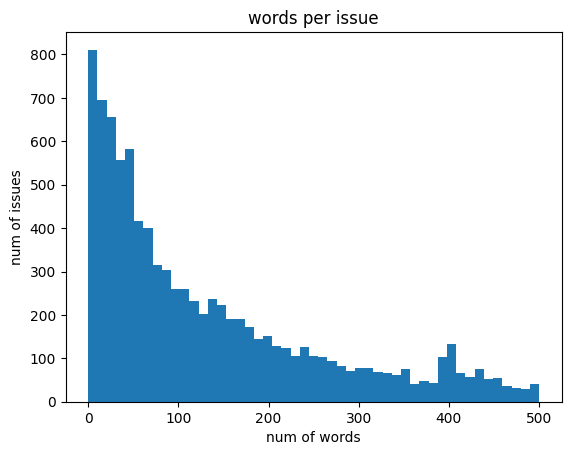

In [14]:
import numpy as np
import matplotlib.pyplot as plt

df["text"].str.split().apply(len).hist(bins=np.linspace(0,500,50), grid=False)
plt.title("words per issue")
plt.xlabel("num of words")
plt.ylabel("num of issues")
plt.show()

### 훈련 세트로 만들기

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit(df["labels"])

mlb. transform([["tokenization", "new model"], ["pytorch"]]) # 라벨의 이진화

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [16]:
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split

def balanced_train_test_split(df, test_size=0.5):
    idx = np.expand_dims(np.arange(len(df)), axis=1)
    lbl = mlb.transform(df["labels"])
    idx_train, _, idx_test, _ = iterative_train_test_split(idx, lbl, test_size=test_size)
    
    return df.iloc[idx_train[:,0]], df.iloc[idx_test[:,0]]

df_clean = df[["text", "labels", "split"]].reset_index(drop=True).copy()

In [17]:
np.random.seed(42)
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]] # 라벨이 없는 데이터 unsupervised
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]] # 라벨이 있는 데이터 supervised

# train, valid, test split in 라벨이 있는 데이터
df_train, df_tmp = balanced_train_test_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_train_test_split(df_tmp, test_size=0.5)

In [18]:
# set as a dataset
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsupervised": Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

/opt/anaconda3/envs/t/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 220
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 110
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 110
    })
    unsupervised: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

### 훈련 슬라이스
- 점진적으로 늘려가며 훈련 데이터셋이 늘어남

In [20]:
import numpy as np

np.random.seed(42)
all_indices = np.expand_dims(list(range(len(ds['train']))),axis=1)
indices_pool = all_indices.copy()
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

In [21]:
for i, k in enumerate(train_samples):
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate([train_slices[-1], new_slice]))
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [22]:
# 목표 분할 크기, # 실제 분할 크기
train_samples, [len(x) for x in train_slices]

([8, 16, 32, 64, 128, 220], [10, 19, 38, 70, 137, 220])

### 베이스 모델 설정(나이브 베이즈 분류기 : Naïve Bayes Classification)

1. 정규 표현식, 수동 규칙이 간단하고, 실제 문제를 잘 해결하기도함
2. 복잡한 모델을 구축하기전에 간단히 데이터의 가용성이 검증이 됨

- **micro** : 자주 등장하는 레이블의 성능 추적
- **macro** : 빈도를 부시하고 모든 레이블에 대한 성능 추적

In [23]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

Map: 100%|██████████| 9303/9303 [00:00<00:00, 370873.59 examples/s]


In [24]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    ds_train_inst = ds["train"].select(train_slice)
    y_train = np.array(ds_train_inst["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # Bag of Words
    count_vect = CountVectorizer() # 단어의 빈도수를 이용한 벡터화

    X_train_count = count_vect.fit_transform(ds_train_inst["text"]) # using fit_transform
    X_test_count = count_vect.transform(ds["test"]["text"]) # using just transform

    clf = BinaryRelevance(classifier=MultinomialNB())
    clf.fit(X_train_count, y_train)

    y_pred = clf.predict(X_test_count)
    clf_report = classification_report(
        y_test, y_pred, target_names=mlb.classes_,zero_division=0 , output_dict=True)
    
    macro_scores["navie_bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["navie_bayes"].append(clf_report["micro avg"]["f1-score"])

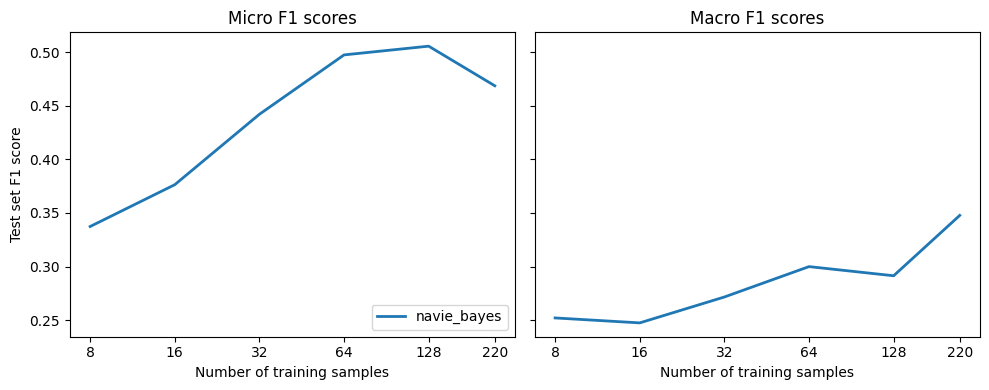

In [26]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")
    
    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

plot_metrics(micro_scores, macro_scores, train_samples, "navie_bayes")

### 제로 샷 분류

- 마스킹된 토큰을 가리고 예측하는 모델
    - my [MASK] movie is MIB.

In [27]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")
pipe("my [MASK] movie is MIB.")[0]["sequence"]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

'my favorite movie is mib.'

In [28]:
for i in pipe("my [MASK] movie is MIB."):
    print(f'{i["token_str"]:12s}: {i["score"]:0.2f}')

favorite    : 0.93
favourite   : 0.04
next        : 0.01
first       : 0.00
new         : 0.00


- target setting

In [29]:
disc = "there are so many things that i like, "
prompt = "[MASK] is my favorate."

out = pipe(disc + prompt, targets=["animal", "car", "that", "this"])
for i in out:
    print(f"{i['token_str']}: {i['score']:0.6f}")

this: 0.175305
that: 0.154841
animal: 0.000023
car: 0.000007


- text entailment : 두개의 텍스트 구절이 연결되는지 파악(모순성 파악)
    - label : premise, hypothsis => entailment, neutral, contradiction. 셋 중 하나의 레이블을 가진다.

In [30]:
# 제로샷 분류
pipe = pipeline("zero-shot-classification", device=0)

sample = ds["train"][0]

out = pipe(sample["text"], list(label_map.values()), multi_label = True)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [31]:
for l,s in zip(out["labels"],out["scores"]):
    print(f"label: {l:20s}, score: {s:0.2f}")

label: new model           , score: 1.00
label: model training      , score: 0.75
label: documentation       , score: 0.59
label: pipeline            , score: 0.49
label: tensorflow or tf    , score: 0.36
label: usage               , score: 0.31
label: examples            , score: 0.29
label: pytorch             , score: 0.28
label: tokenization        , score: 0.22


In [32]:
def zero_shot_pipe(example):
    out = pipe(example["text"], list(label_map.values()),multi_label=True)
    example["predicted_labels"] = out["labels"]
    example["scores"] = out["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipe)

Map: 100%|██████████| 110/110 [08:04<00:00,  4.40s/ examples]


In [33]:
def get_pred(example, threshold=None, top_k=None):
    pred = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score > threshold:
                pred.append(label)
    elif top_k:
        pred = example["predicted_labels"][:top_k]
    else:
        raise ValueError("threshold or top_k should be provided")
    return {"pred_label_ids" : list(np.squeeze(mlb.transform([pred])))}

def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=list(label_map.values()), zero_division=0, output_dict=True
    )

macros_by_k, micros_by_k = [], []
top_ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for top_k in top_ks:
    ds_zero_shot = ds_zero_shot.map(get_pred, batched=False,
                                    fn_kwargs={"top_k": top_k})
    clf_report = get_clf_report(ds_zero_shot)
    micros_by_k.append(clf_report["micro avg"]["f1-score"])
    macros_by_k.append(clf_report["macro avg"]["f1-score"])

thresholds = np.linspace(0.1, 1.0, 100)
macros_by_th, micros_by_th = [], []
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_pred, batched=False,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros_by_th.append(clf_report["micro avg"]["f1-score"])
    macros_by_th.append(clf_report["macro avg"]["f1-score"])

Map: 100%|██████████| 110/110 [00:00<00:00, 6929.09 examples/s]


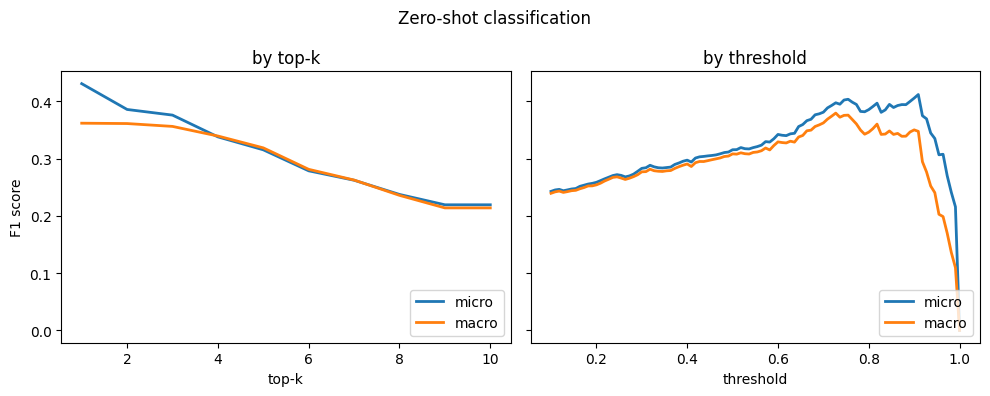

In [34]:
# drowing
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
ax0.plot(top_ks, micros_by_k, label="micro", linewidth=2)
ax0.plot(top_ks, macros_by_k, label="macro", linewidth=2)
ax1.plot(thresholds, micros_by_th, label="micro", linewidth=2)
ax1.plot(thresholds, macros_by_th, label="macro", linewidth=2)
ax0.set_title("by top-k"), ax1.set_title("by threshold")
ax0.set_ylabel("F1 score")
ax0.legend(loc="lower right"), ax1.legend(loc="lower right")
for ax in [ax0, ax1]:
    ax.set_xlabel("top-k" if ax == ax0 else "threshold")
    ax.minorticks_off()

fig.suptitle("Zero-shot classification")
plt.tight_layout()
plt.show()

### 제로샷 vs 나이브

Map: 100%|██████████| 110/110 [00:00<00:00, 3984.33 examples/s]


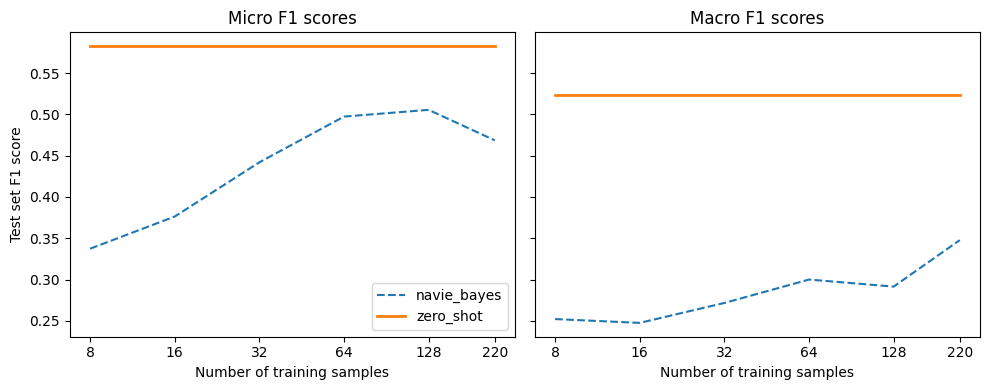

In [35]:
ds_zero_shot = ds["test"].map(zero_shot_pipe)
ds_zero_shot = ds_zero_shot.map(get_pred, batched=False, fn_kwargs={"top_k": 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores["zero_shot"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["zero_shot"].append(clf_report["micro avg"]["f1-score"])
plot_metrics(micro_scores, macro_scores, train_samples, "zero_shot")

### Data Augmentation

- 역 번역(back translation)
    - 원본 언어 -> 하나 이상의 타깃 언어로 번역 -> 원본 언어로 다시 번역
    - 말뭉치가 많지 않은 말뭉치에서 잘 작동한다.
    - **M2M100** 을 이용하면 역번역을 구현 할 수 있다.
- 토큰 섞기
    - 훈련 세트의 하나의 문맥 안에서 동의어 교체, 추가, 교환, 삭제등의 간단한 변환을 한다.
    - **NlpAug, TextAttack** 등을 이용하여 토큰변환 기법을 이용할 수 있다.

In [36]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(42)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased",
                                device=0, action="substitute")

In [37]:
text = "Transformers are the most popular toys"
aug.augment(text)

['these are the most popular tools']

In [46]:
def augment_text(batch, transformer_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
    for _ in range(transformer_per_example):
        text_aug += aug.augment(text)
        label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

ds_train_sample = ds_train_inst.map(augment_text, batched=True,
                                      remove_columns=ds_train_inst.column_names).shuffle(seed=42)

Map: 100%|██████████| 220/220 [00:00<00:00, 401.12 examples/s]


In [149]:
ds_train_sample

Dataset({
    features: ['text', 'label_ids'],
    num_rows: 221
})

In [426]:
from datasets import concatenate_datasets
# 데이터셋 합치기
auged_dataset = concatenate_datasets([ds["train"], ds_train_sample]).shuffle()

In [428]:
# 기존 데이터와 aug 데이터 합치기
for train_slice in train_slices:
    ds_train_inst = auged_dataset.select(train_slice)
    y_train = np.array(ds_train_inst["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # Bag of Words
    count_vect = CountVectorizer() # 단어의 빈도수를 이용한 벡터화

    X_train_count = count_vect.fit_transform(ds_train_inst["text"]) # using fit_transform
    X_test_count = count_vect.transform(ds["test"]["text"]) # using just transform

    clf = BinaryRelevance(classifier=MultinomialNB())
    clf.fit(X_train_count, y_train)

    y_pred = clf.predict(X_test_count)
    clf_report = classification_report(
        y_test, y_pred, target_names=mlb.classes_,zero_division=0 , output_dict=True)
    
    macro_scores["navie_bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["navie_bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

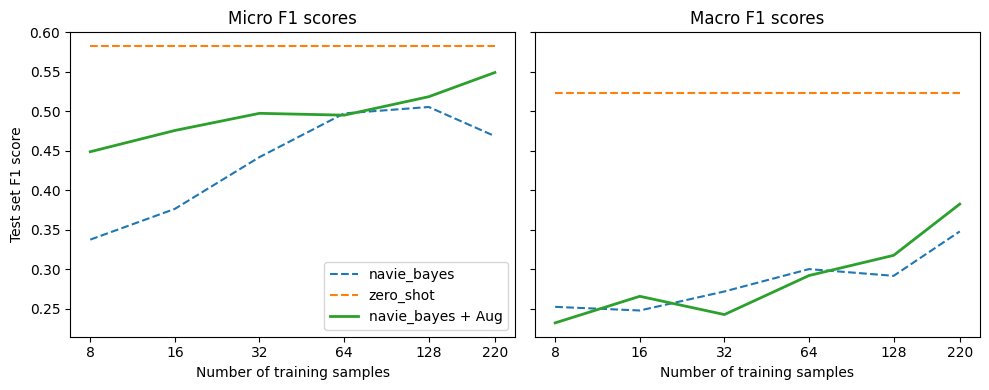

In [429]:
plot_metrics(micro_scores, macro_scores, train_samples, "navie_bayes + Aug")

### 임베딩을 룩업 테이블로 사용 (gpt2 모델 임베딩 아웃풋을 전통적인 머신러닝 분류 문제로)

In [433]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [438]:
# 평균 풀링
def meanpooling(model_output, attention_mask):
    # 토큰 임베딩 추출
    token_embeddings = model_output[0]

    # 어텐션 마스크 계산
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())

    # 마스킹 된 토큰 제외 임베딩 합
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    # 평균 벡터 계산
    return sum_embeddings / sum_mask
def embed_text(example):
    inputs = tokenizer(example["text"], return_tensors="pt", max_length=128, padding=True, truncation=True)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embed = meanpooling(model_output, inputs["attention_mask"])
    return {"embeddings": pooled_embed}

tokenizer.pad_token = tokenizer.eos_token

In [439]:
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   7%|▋         | 16/220 [00:22<04:42,  1.38s/ examples]


KeyboardInterrupt: 